In [1]:
# The purpose of this notebook is to make noise patches from different sized FOVS and measure their changing NPS

In [4]:
from pathlib import Path
import numpy as np
import seaborn as sns

import sys
sys.path.append('..')

sns.set_theme()
sns.set_style('white')

from nps_utils import compute_nps, radial_profile


In [6]:
from make_noise_patches import prep_patches

patch_size = (30, 30)
datadir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CCT189_peds/CCT189_peds_fbp/')
noise_patch_dict = prep_patches(datadir, patch_size=patch_size)

generating noise images from the following phantom scans: dict_keys(['diameter350mm', 'diameter112mm', 'diameter185mm', 'diameter200mm', 'diameter216mm', 'diameter131mm', 'diameter292mm', 'diameter151mm'])


100%|██████████| 8/8 [00:12<00:00,  1.62s/it]


extracting noise patches...


100%|██████████| 8/8 [00:01<00:00,  7.35it/s]


In [7]:
dose=100
from make_noise_patches import load_mhd
sa_file_dict={d.stem : next(d.rglob(f'dose_{dose:03d}/*/signal_absent.mhd')) for d in datadir.glob('diameter*mm')}

In [8]:
sa = load_mhd(sa_file_dict['diameter292mm'])
sa.shape

sa_image_dict = {k: load_mhd(v)-1000 for k, v in sa_file_dict.items()}

## uniform water phantom scans

Let's look at the phantoms scans of the uniform water phantoms, 200 repeat simulations were performed each with unique projection domain noise instances. No

In [50]:
import matplotlib.pyplot as plt
def ctshow(im, vmin=None, vmax=None):
    plt.subplots(1,1, dpi=300)
    im = plt.imshow(im,cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.015, pad=0.01, label='HU')
    plt.axis('off')

Text(0.5, 1.0, '[112, 151, 292] mm')

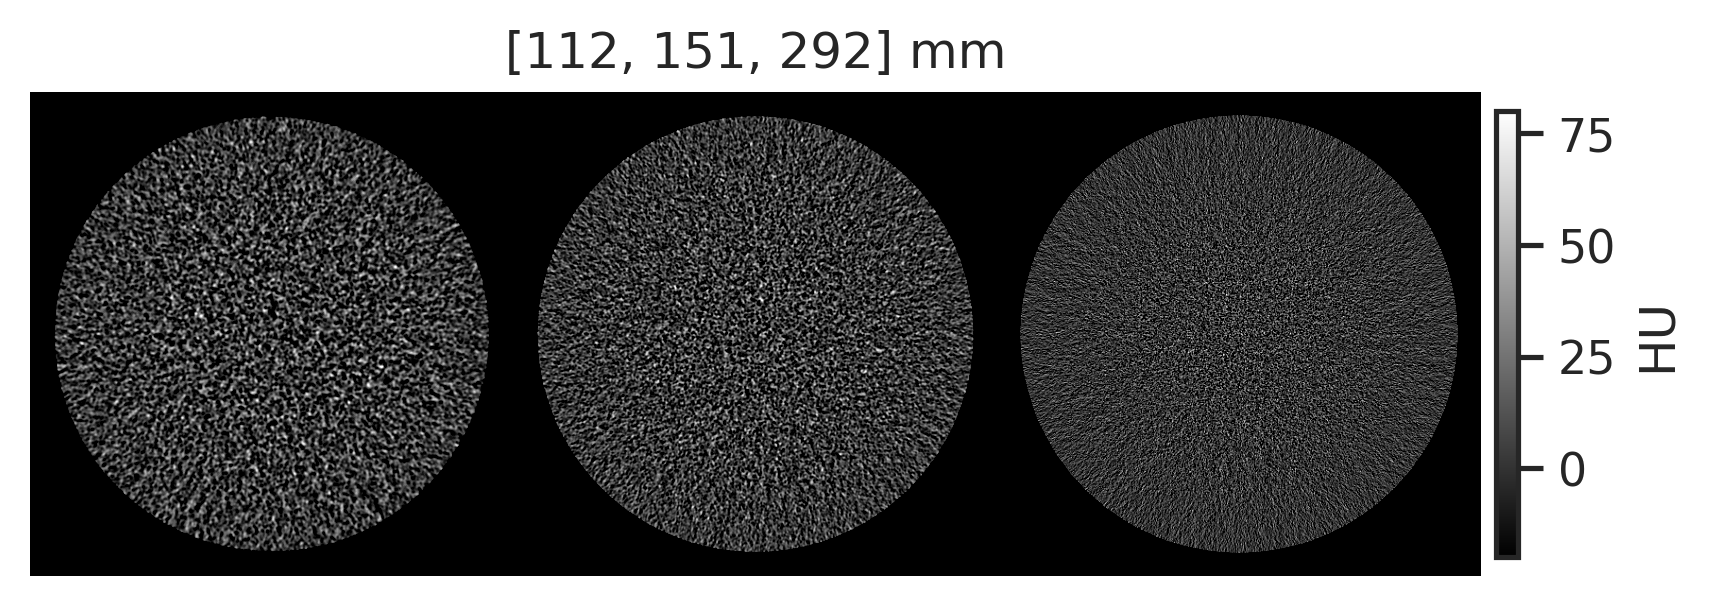

In [51]:
import matplotlib.pyplot as plt
diams = [112, 151, 292]
ctshow(np.concatenate([sa_image_dict[f'diameter{x}mm'][0] for x in diams], axis=1),vmin=-20, vmax=80)
plt.title(f'{diams} mm')

In [52]:
import numpy as np
from make_noise_patches import make_noise_images
max_images = 100
make_noise_images(sa_image_dict['diameter112mm'], max_images=max_images).shape

(100, 512, 512)

In [53]:
noise_image_dict = {k: make_noise_images(v, max_images) for k, v in sa_image_dict.items()}

## Now look at noise images

Text(0.5, 1.0, '[112, 151, 292] mm whole noise images')

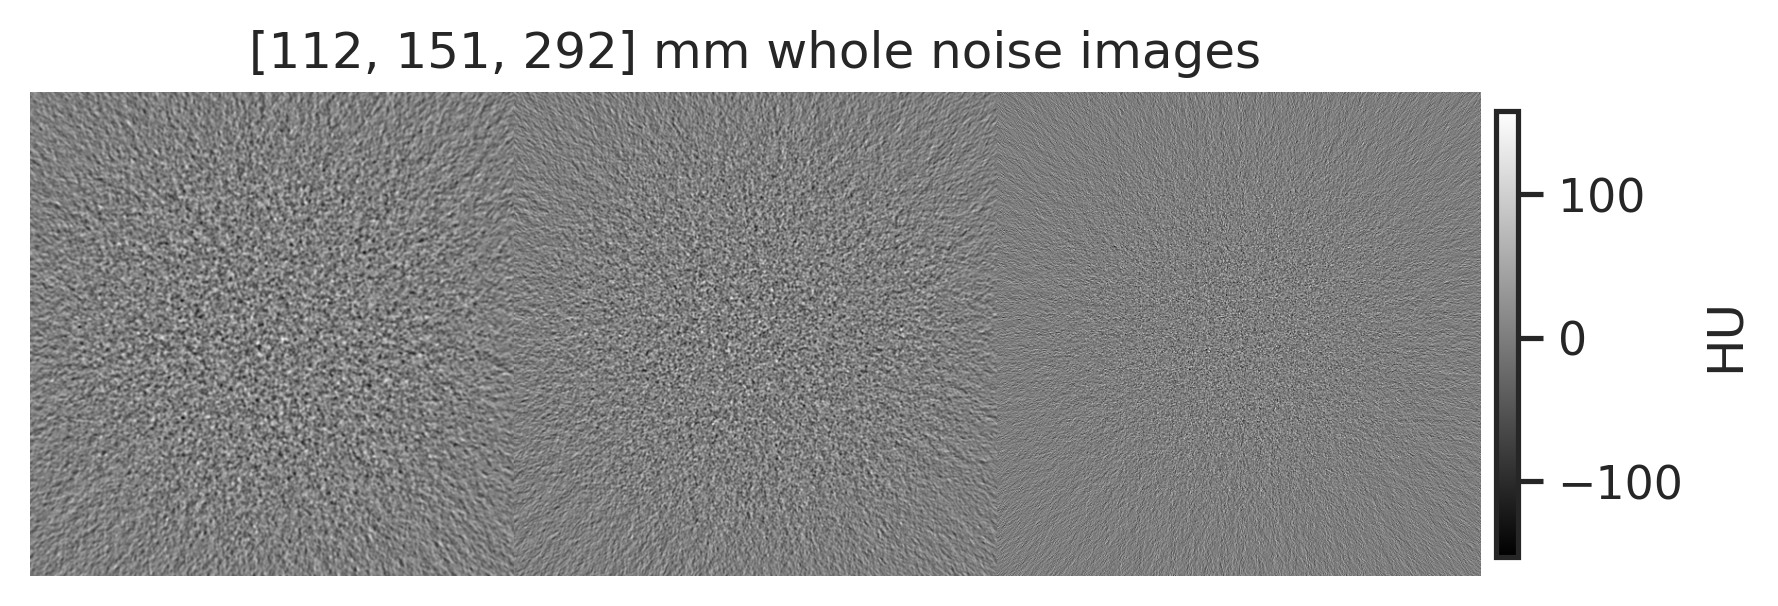

In [54]:
diams = [112, 151, 292]
ctshow(np.concatenate([noise_image_dict[f'diameter{x}mm'][0] for x in diams], axis=1))
plt.title(f'{diams} mm whole noise images')

In [55]:
diams = [112, 151, 292, 350]
nps_images = [compute_nps(noise_image_dict[f'diameter{x}mm']) for x in diams]

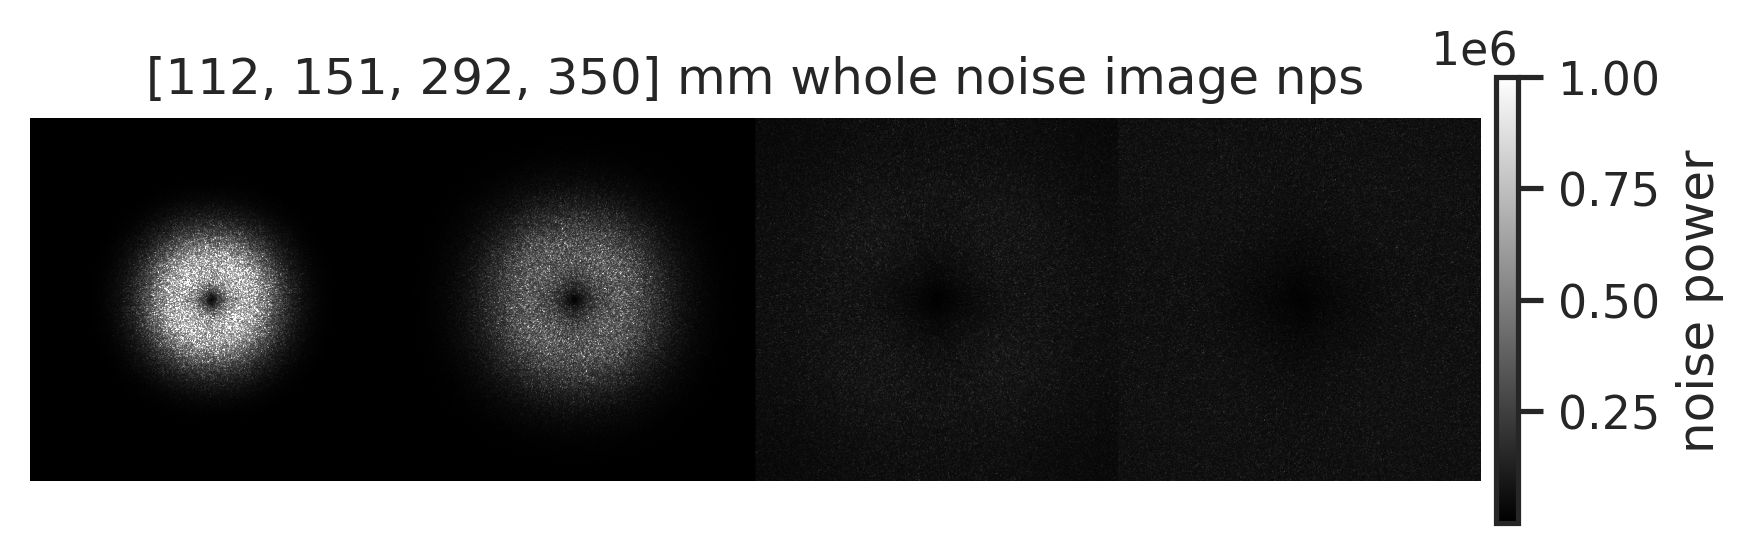

In [62]:
plt.subplots(1,1, dpi=300)
plt.imshow(np.concatenate(nps_images, axis=1), cmap='gray', vmax=1e6)
plt.axis('off')
plt.title(f'{diams} mm whole noise image nps')
plt.colorbar(fraction=0.015, pad=0.01, label='noise power')

 noise texture changes radially and azimuthally

In [63]:
from pathlib import Path
data_dir = Path('../data/')

# load training data, used to update CNN weights
# 2000 30x30 image patches from 8 patients
train_input = np.load(data_dir/'Denoising_Data/train_input.npy')
train_target = np.load(data_dir/'Denoising_Data/train_target.npy')
# load validation data, used to monitor for overfitting
# 1000 30x30 image patches from 1 patient
val_input = np.load(data_dir/'Denoising_Data/val_input.npy')
val_target = np.load(data_dir/'Denoising_Data/val_target.npy')

# load testing data, used for evaluating performance
# 5 512x512 images from 1 patient
test_input = np.load(data_dir/'Denoising_Data/test_input.npy')
test_target = np.load(data_dir/'Denoising_Data/test_target.npy')

# Load examples images from state-of-the-art CNN denoising for CT images
test_example = np.load(data_dir/'Denoising_Data/test_input_denoised.npy')

print('Data loading completed.')

Data loading completed.


## Look at representative patchesnoise pasnoise in C
T
 imnon-stationy, so by sampling noise from different parts of the image, central vs peripheral and different azimuthal locations shows differences in noiese textur

generating noise images from the following phantom scans: dict_keys(['diameter350mm', 'diameter112mm', 'diameter185mm', 'diameter200mm', 'diameter216mm', 'diameter131mm', 'diameter292mm', 'diameter151mm'])


100%|██████████| 8/8 [00:00<00:00, 13.61it/s]


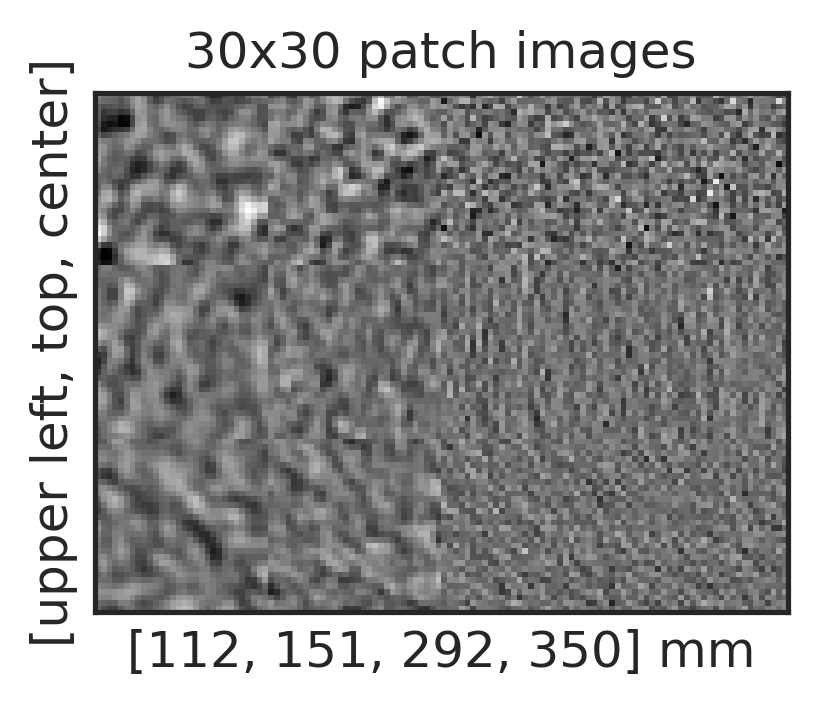

In [80]:
from make_noise_patches import make_noise_image_dict

def get_square_patch(img, center, patch_width=30):
    if img.ndim == 2: img = img[None, :, :]
    return img[:, center[0]-patch_width//2:center[0]+patch_width//2, center[1]-patch_width//2:center[1]+patch_width//2]

def get_patches(img, centers, patch_size=30):
    return {center: get_square_patch(img, center, patch_width=patch_size) for center in centers}

def plot_representative_noise_patches(datadir, patch_size=30):
    centers = [(256, 256), (50, 256), (110, 110)]
    noise_image_dict = make_noise_image_dict(datadir)
    corner_patches = [get_patches(noise_image_dict[f'diameter{x}mm'], centers=centers, patch_size=patch_size) for x in diams]

    corners= list(corner_patches[0].keys())
    f, axs = plt.subplots(1,1, dpi=300, figsize=(3,2.25))
    region_patches = np.concatenate([np.concatenate([p[c][0] for p in corner_patches], axis=1) for c in corners])
    axs.imshow(region_patches, cmap='gray')
    axs.set_title(f'{patch_size}x{patch_size} patch images')
    axs.set_xlabel(f'{diams} mm')
    axs.set_ylabel(f'[upper left, top, center]')
    axs.set_xticks([])
    axs.set_yticks([])
    return corner_patches, corners

corner_patches, corners = plot_representative_noise_patches(datadir, patch_size=30)

[]

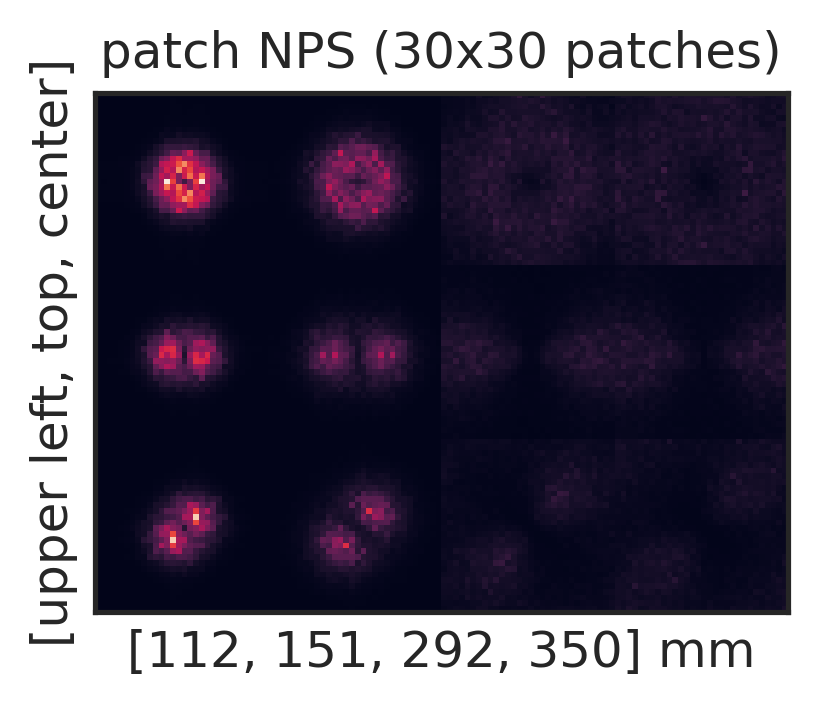

In [81]:
f, axs = plt.subplots(1,1, dpi=300, figsize=(3,2.25))
axs.imshow(np.concatenate([np.concatenate([compute_nps(p[c]) for p in corner_patches], axis=1) for c in corners]))
axs.set_title('patch NPS (30x30 patches)')
axs.set_xlabel(f'{diams} mm')
axs.set_ylabel(f'[upper left, top, center]')
axs.set_xticks([])
axs.set_yticks([])

In [82]:
normalize = lambda x: x/x.sum()
patch_nps = [normalize(compute_nps(noise_patch_dict[f'diameter{x}mm'])) for x in diams]

Text(0.5, 1.0, '[112, 151, 292, 350] mm averaged patch nps (30x30 patches)')

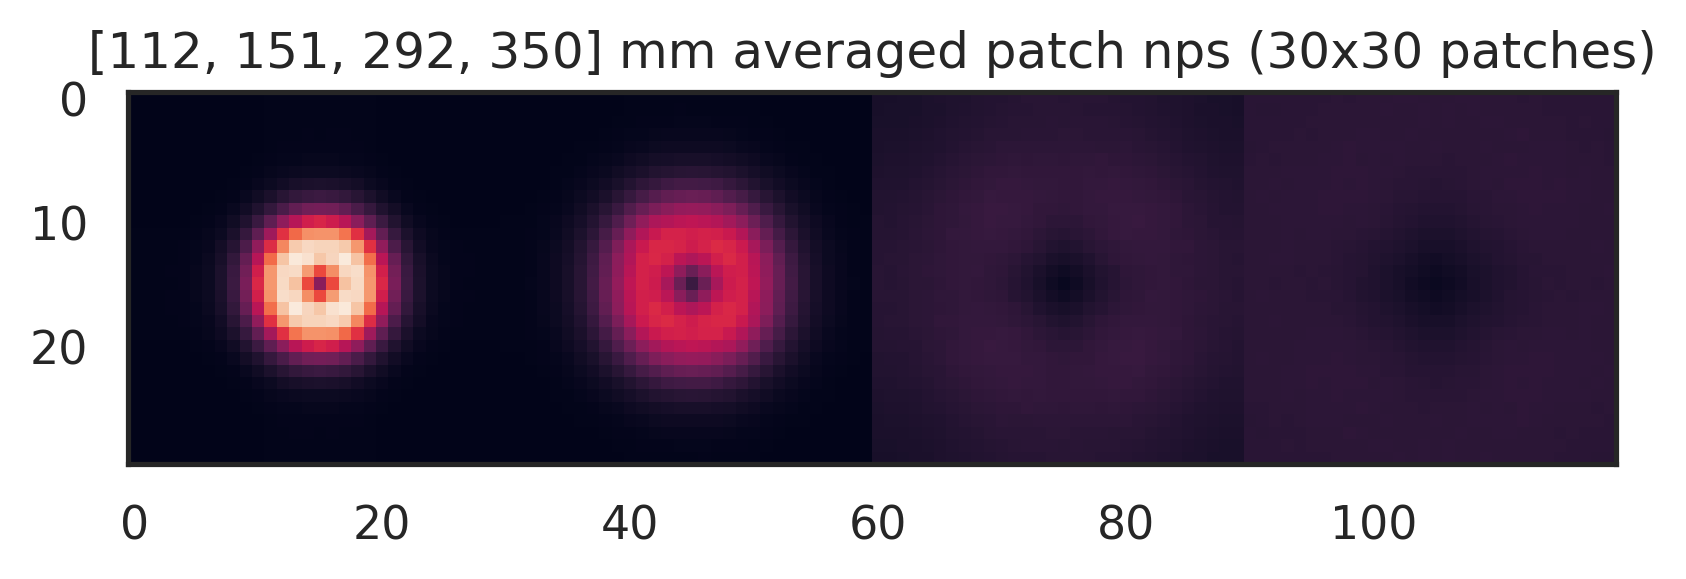

In [83]:
plt.subplots(1,1, dpi=300)
plt.imshow(np.concatenate(patch_nps, axis=1))
plt.title(f'{diams} mm averaged patch nps (30x30 patches)')

Looking at slightly larger patch sizes, 6x64 was used t o trained REDCNN

generating noise images from the following phantom scans: dict_keys(['diameter350mm', 'diameter112mm', 'diameter185mm', 'diameter200mm', 'diameter216mm', 'diameter131mm', 'diameter292mm', 'diameter151mm'])


100%|██████████| 8/8 [00:00<00:00, 13.90it/s]


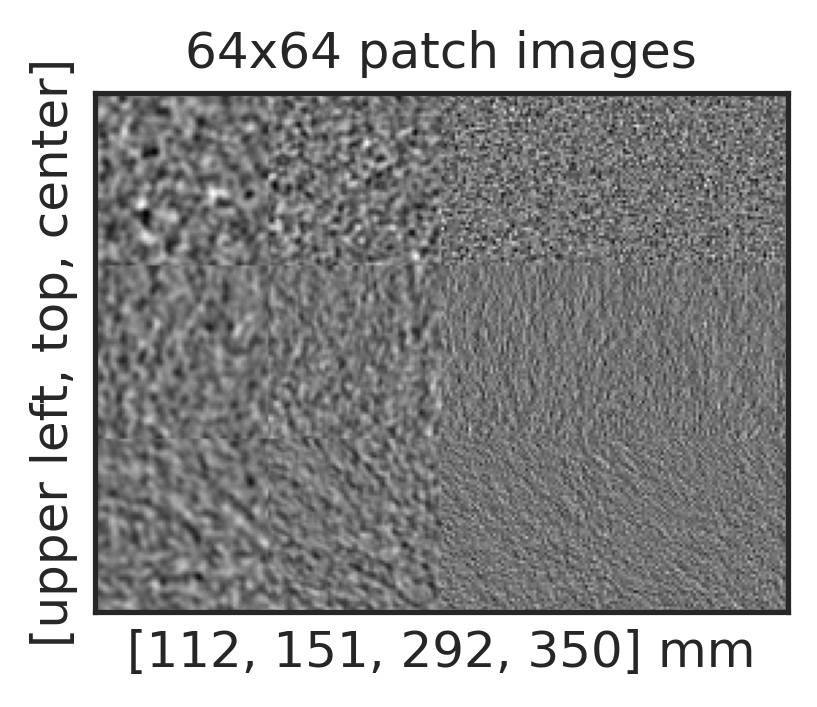

In [84]:
corner_patches, corners = plot_representative_noise_patches(datadir, patch_size=64)

[]

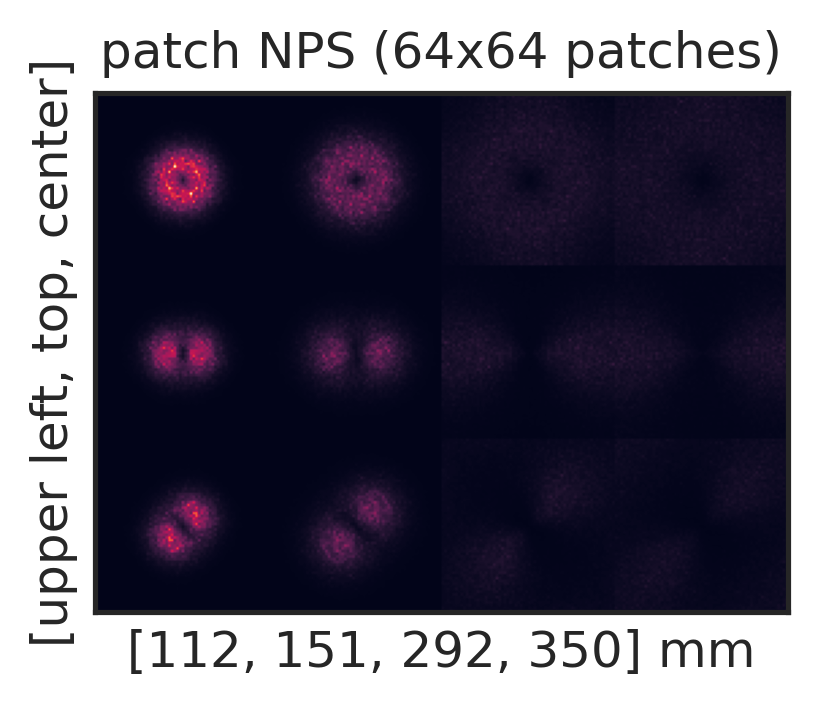

In [85]:
f, axs = plt.subplots(1,1, dpi=300, figsize=(3,2.25))
axs.imshow(np.concatenate([np.concatenate([compute_nps(p[c]) for p in corner_patches], axis=1) for c in corners]))
axs.set_title('patch NPS (64x64 patches)')
axs.set_xlabel(f'{diams} mm')
axs.set_ylabel(f'[upper left, top, center]')
axs.set_xticks([])
axs.set_yticks([])

In [86]:
normalize = lambda x: x/x.sum()
patch_nps = [normalize(compute_nps(noise_patch_dict[f'diameter{x}mm'])) for x in diams]

Text(0.5, 1.0, '[112, 151, 292, 350] mm averaged patch nps (64x64 oatches)')

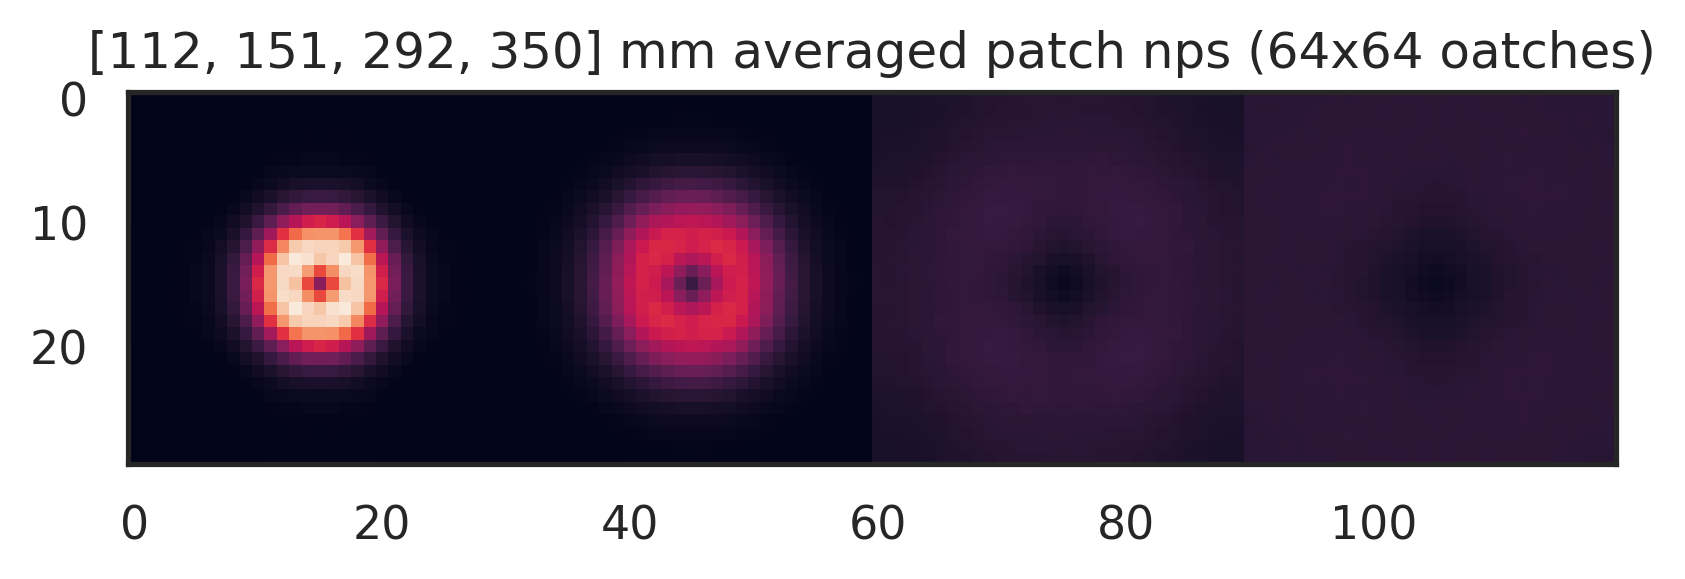

In [87]:
plt.subplots(1,1, dpi=300)
plt.imshow(np.concatenate(patch_nps, axis=1))
plt.title(f'{diams} mm averaged patch nps (64x64 patches)')

 how do these generated noise patches compare to the training dataset noise patches?

NameError: name 'train_nps' is not defined

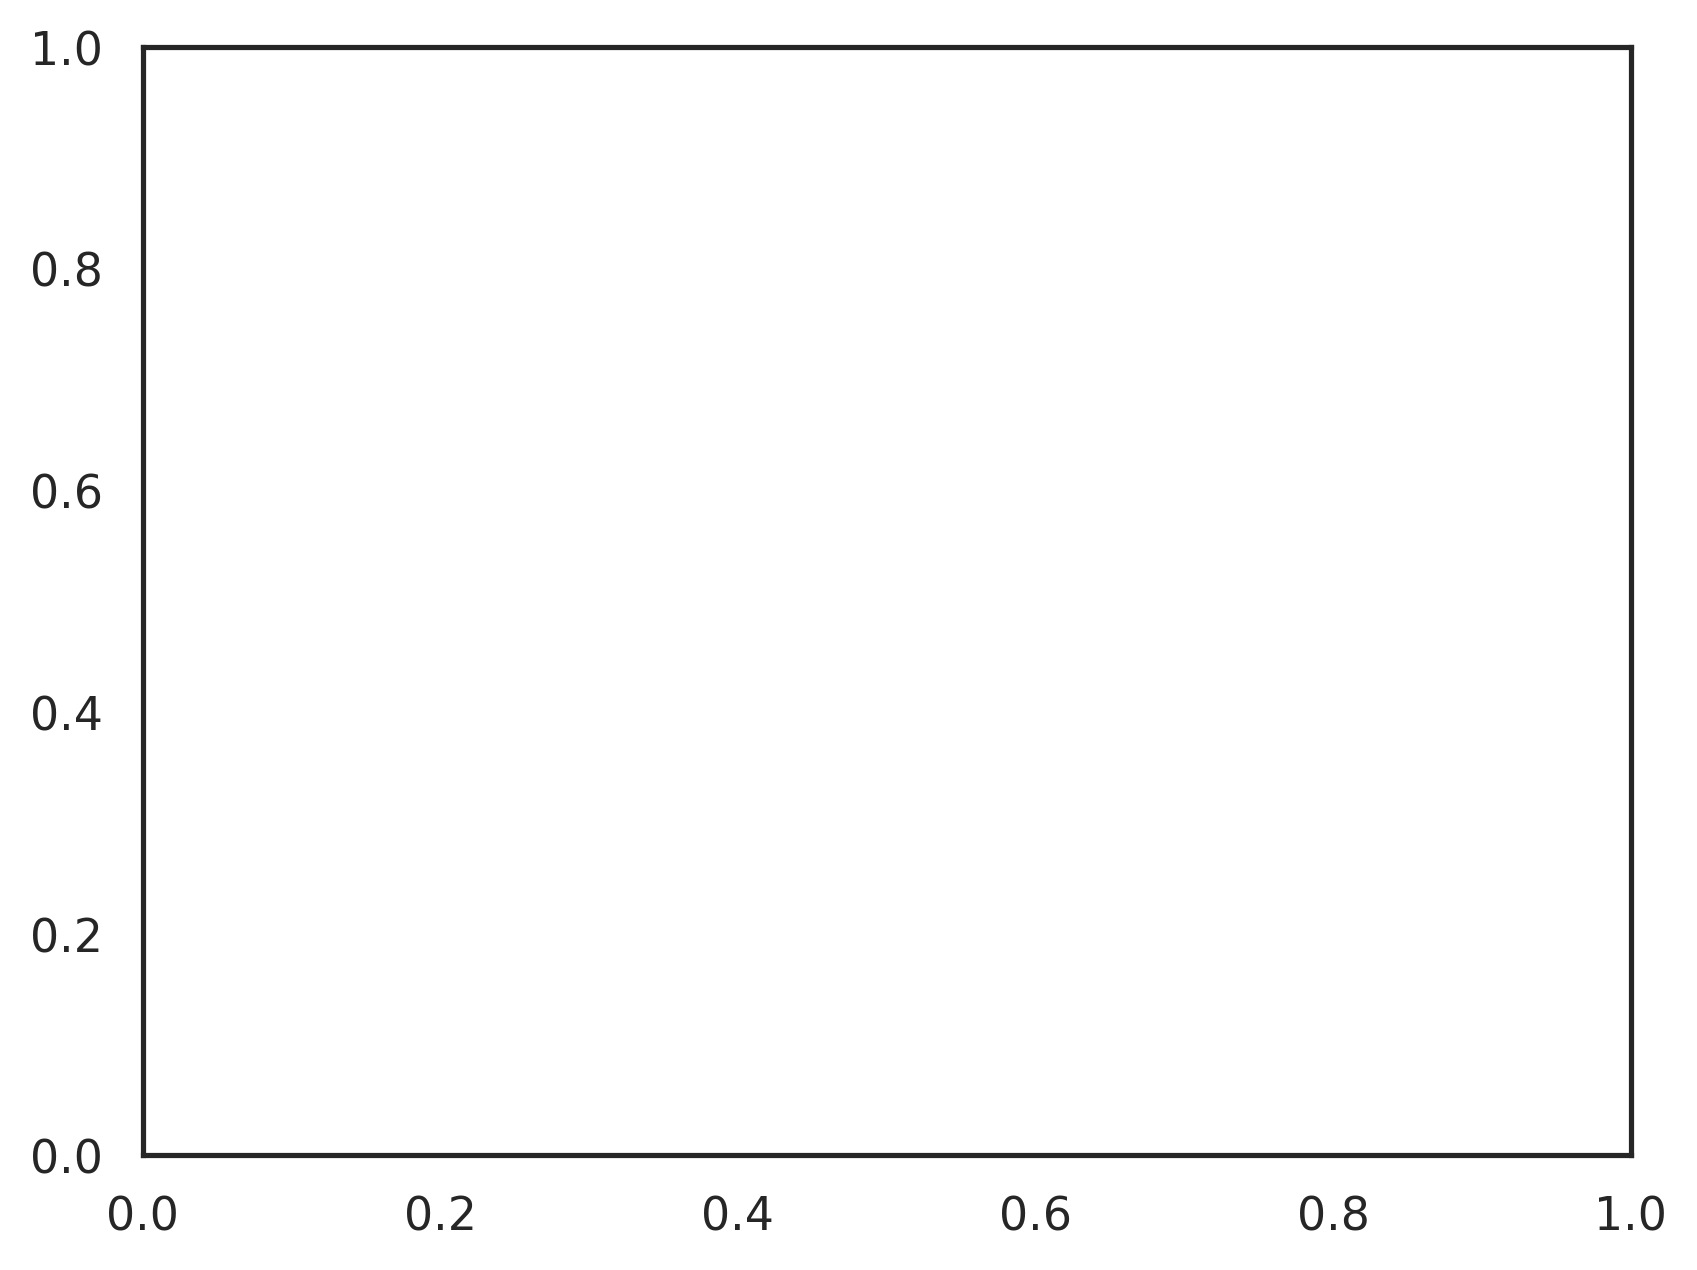

In [88]:
plt.subplots(1,1, dpi=300)
plt.imshow(np.concatenate([*patch_nps, normalize(train_nps)], axis=1))
for idx, d in enumerate([*diams, 'training']):
    plt.annotate(f'{d}', (10 + idx*30, 5))
plt.axis('off')

NameError: name 'train_nps' is not defined

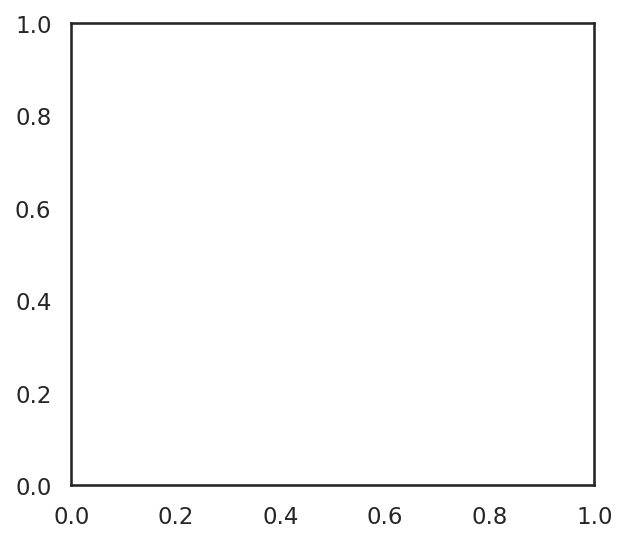

In [89]:
f, axs = plt.subplots(figsize=(4.5, 4), dpi=150)
for nps, diam in zip([normalize(train_nps), *patch_nps], ['training', *diams]):
    axs.plot(radial_profile(nps), label=diam)
plt.xlabel('Spatial Frequency [1/px]')
plt.ylabel('Unnormalized NPS')
plt.legend(title='diameters [mm]')
plt.title('Generated Noise NPS vs. Training Patch NPS')

 now save the noise patches